In [2]:
from ase.io import read
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('~/plot.mplstyle')
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['mathtext.default']='regular'
cm=1/2.54
import pandas as pd

In [3]:
from tempfile import NamedTemporaryFile
from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier
from ase.io import write
from ase.atoms import Atoms
from pymatgen.analysis.diffraction.neutron import ATOMIC_SCATTERING_LEN
from pymatgen.analysis.diffraction.xrd import WAVELENGTHS, ATOMIC_SCATTERING_PARAMS
 
def Sq_from_gr(r, gr, q, rho_av):
    '''Calculate Sq from partial g(r)
    r :: (array) distance values
    gr :: (array) partial g(r) (same shape as r)
    q :: (array) q values to calculate
    rho_av :: (float) average density'''
    sq = []
    for k in q:
        s = np.trapz(r*(gr-1)*np.sin(k*r)/k, x=r)
        sq.append(s)
    return 1 + 4*np.pi*rho_av*np.array(sq)
 
def calc_f(symbol, q):
    '''Calculate xray scattering factor for a given species'''
    z = Atoms(symbol).get_atomic_numbers()[0]
    s2 = (q/(4*np.pi))**2
    xsf = ATOMIC_SCATTERING_PARAMS[symbol]
    f = z - 41.78214 * s2 * np.sum(
                         np.vstack([d[0] * np.exp(-d[1] * s2) for d in xsf]), axis=0)
                         
    return f
 
def Sq(atoms, cutoff, q=np.linspace(0.01, 12, 1000), bins=1000):
    '''Calculate Sq from an atoms object. Uses ovito, so will scale well with system size
    Parameters:
    atoms :: (ase.Atoms) atoms object
    cutoff :: (float) cutoff for rdf
    q :: (array) q values to calculate
    bins :: (int) number of bins for rdf
    Returns:
    Sqs :: (dict) dictionary of FZ partial Sq values for each species,
                    with species names as key. e.g. Mo-Mo, Mo-S
                    and total Sq as 'total_neutron' and 'total_xray'. Should be
                    the same thing for a monospecies system.
    '''
 
    with NamedTemporaryFile(suffix='.xyz') as f:
        write(f.name, atoms)
        pipe = import_file(f.name)
    
    pipe.modifiers.append(
        CoordinationAnalysisModifier(
            cutoff=cutoff,
            number_of_bins=bins,
            partial=True))
    data = pipe.compute() # expensive operation
 
    rdf_table = data.tables['coordination-rdf']             
    rdf_names = rdf_table.y.component_names
    # print('Species ', rdf_names)
    r = rdf_table.xy().T[0]          ### x-coordinates
    rdfs = {}                        ### dictionary to store partial RDFs
    for component, name in enumerate(rdf_names):
        rdfs[name] = rdf_table.y[:,component]
 
    species, counts = np.unique(atoms.symbols, return_counts=True)
 
    nsf = {i: ATOMIC_SCATTERING_LEN[i] for i in species} # neutron scattering lengths (q-independent)
    fs = {f'{i}': calc_f(i, q) for i in species} # xray scattering factors (q-dependent)
    
    nsfs = {f'{i}-{j}': nsf[i]*nsf[j] for i in species for j in species}
    xsfs = {f'{i}-{j}': fs[i]*fs[j] for i in species for j in species}
                            
    total = sum(counts)
    conc = [count/total for i, count in zip(species, counts)]
    concs = {f'{val}-{val2}': conc[i]*conc[j] \
        for i, val in enumerate(species) \
        for j, val2 in enumerate(species)}
    density = data.particles.count/data.cell.volume
 
    Sqs = {}     ### dictionary to store partial Sq
    for pair in rdfs.keys():
        rho = density * concs[pair]
        rdf = rdfs[pair]  ### partial rdf
        Sqs[pair] =  list(Sq_from_gr(r, rdf, q, rho))
 
    # total S(Q)
    Sq_sum_n = np.zeros(len(q))
    Sq_sum_x = np.zeros(len(q))
    av_n = np.sum([conc[i]*val for i, val in enumerate(nsf.values())], axis=0)**2
    av_x = np.sum([conc[i]*val for i, val in enumerate(fs.values())], axis=0)**2
    for pair in rdfs.keys():
        if len(np.unique(pair.split('-'))) != 1:                           
                Sq_sum_n +=  2*((concs[pair] * nsfs[pair] * np.asarray(Sqs[pair]))/av_n)
                Sq_sum_x +=  2*((concs[pair] * xsfs[pair] * np.asarray(Sqs[pair]))/av_x)
        else:
                Sq_sum_n += concs[pair] * nsfs[pair] * np.asarray(Sqs[pair]) / av_n
                Sq_sum_x +=  concs[pair] * xsfs[pair] * np.asarray(Sqs[pair]) / av_x
 
    Sqs['total_neutron'] = list(Sq_sum_n)
    Sqs['total_xray'] = list(Sq_sum_x)
    Sqs['q'] = list(q)
    
    return Sqs

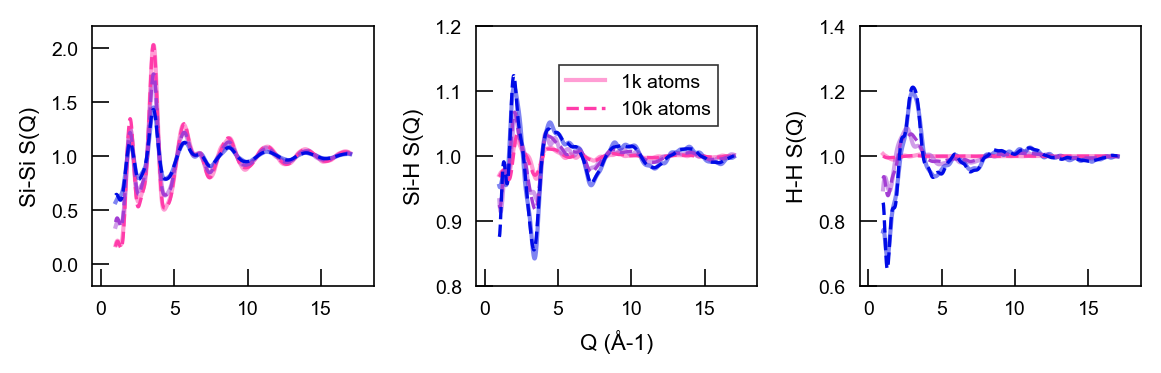

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15*cm, 5*cm), sharex=True)
Hconcs = [5, 25, 50]


q=np.linspace(1, 17, 1000)
bins=10000
cutoff=10

colors_rgb = [
    mcolors.to_rgb('#FF3CAA'),  
    mcolors.to_rgb('#BE43BE'),
    mcolors.to_rgb('#6C32FF'), 
    mcolors.to_rgb('#000BE6')   
]
custom_cmap = LinearSegmentedColormap.from_list('custom_hsla_gradient', colors_rgb)
norm = mcolors.Normalize(vmin=min(Hconcs), vmax=max(Hconcs))  # Normalize Hconc range 


for i, Hconc in enumerate(Hconcs):
    color = custom_cmap(norm(Hconc))
    wdir = f'../Hconc-{Hconc:.0f}/1'
    atoms = read(f'{wdir}/out_anneal_SiH.data', format='lammps-data', atom_style='atomic')

    try:
        Sqs = np.load(f'{wdir}/Sq.npy',allow_pickle='TRUE').item()
    except:
        Sqs=Sq(atoms, cutoff, q=q , bins=bins)
        np.save(f'{wdir}/Sq.npy', Sqs) 


    Sq_HH_av=Sqs['H-H']
    Sq_HSi_av=Sqs['H-Si']
    Sq_SiSi_av=Sqs['Si-Si']

    axes[0].plot(q, Sq_SiSi_av, color=color, alpha=0.5, linewidth=1.5)
    axes[1].plot(q, Sq_HSi_av, color=color, alpha=0.5, linewidth=1.5, label='1k atoms')
    axes[2].plot(q, Sq_HH_av, color=color, alpha=0.5, linewidth=1.5)


for i, Hconc in enumerate(Hconcs):
    color = custom_cmap(norm(Hconc))

    wdir = f'./Hconc-{Hconc:.0f}'
    atoms = read(f'{wdir}/out_anneal_SiH.data', format='lammps-data', atom_style='atomic')

    try:
        Sqs = np.load(f'{wdir}/Sq.npy',allow_pickle='TRUE').item()
    except:
        Sqs=Sq(atoms, cutoff, q=q , bins=bins)
        np.save(f'{wdir}/Sq.npy', Sqs) 


    Sq_HH_av=Sqs['H-H']
    Sq_HSi_av=Sqs['H-Si']
    Sq_SiSi_av=Sqs['Si-Si']


    axes[0].plot(q, Sq_SiSi_av, color=color, alpha=1, linestyle='--', linewidth=1.2)
    axes[1].plot(q, Sq_HSi_av, color=color, alpha=1, linestyle='--', linewidth=1.2, label='10k atoms')
    axes[2].plot(q, Sq_HH_av, color=color, alpha=1, linestyle='--', linewidth=1.2)


handles, labels = axes[1].get_legend_handles_labels()

# Filter out specific items you don't want (e.g., "Remove this")
filtered_handles = handles[::3]
filtered_labels = labels[::3]

axes[1].legend(filtered_handles, filtered_labels,loc=1)
axes[0].set_ylabel('Si-Si S(Q)')
axes[0].set_ylim(bottom=-0.2, top=2.2)
axes[0].set_yticks(np.arange(0,2.5,0.5))

axes[1].set_ylabel('Si-H S(Q)')
axes[1].set_ylim(bottom=0.8, top=1.2)
axes[1].set_yticks(np.arange(0.8,1.3,0.1))

axes[2].set_ylabel('H-H S(Q)')
axes[1].set_xlabel('Q (Å-1)')
axes[2].set_ylim(bottom=0.6, top=1.4)
axes[2].set_yticks(np.arange(0.6,1.5,0.2))

fig.tight_layout()
